In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from torchinfo import summary
from tqdm.auto import tqdm
import cv2
import pathlib
from enum import Enum
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
import re

c:\Proyectos\PAPER\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device diagnostic

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## PatchEmbedding

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()

        self.patcher=nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
        self.flatten=nn.Flatten(start_dim=2,end_dim=3) #only flatten the feature map dimension

        self.patch_size=patch_size
    
    def forward(self,x:torch.tensor):
        #image_resolution=x.shape[-1] #quadratic images
        bs,frames,channels,height,width=x.shape
        #print(f"Image resolution {image_resolution}")
        assert height % self.patch_size == 0, f"Input image size must be divisible by patch size"

        x=x.view(bs*frames,channels,height,width)
        
        x_patched=self.patcher(x)

        #print(f"Shape after Patch Embedding {x_patched.shape}")

        x_flattened=self.flatten(x_patched)

        #print(f"Shape after flatten {x_flattened.shape}")

        x=x_flattened.permute(0,2,1)

        _,n_patches,emb_dim=x.shape

        x=x.view(bs,frames,n_patches,emb_dim)

        return x

## Tubelet embedding

In [4]:
class TubeletEmbedding(nn.Module):
    def __init__(self, in_channels:int=3,
                tubelet_size:tuple=(2,16,16),
                d_model:int=768):
        super().__init__()

        self.patcher=nn.Conv3d(in_channels=in_channels,
                            out_channels=d_model,
                            kernel_size=tubelet_size,
                            stride=tubelet_size)
        
        self.flatten=nn.Flatten(start_dim=3,end_dim=4)
        
    def forward(self,x:torch.tensor):
        x=x.permute(0,2,1,3,4)
        x_patched=self.patcher(x)
        #print(f"Shape after the pacth embedding: {x_patched.shape}")
        x_flatten=self.flatten(x_patched)
        #print(f"Shape after the flatten: {x_flatten.shape}")
        x=x_flatten.permute(0,2,3,1)
        #print(f"Shape after the permute: {x.shape}")
        return x

In [5]:
tensor_sample=torch.randn((32,10,3,224,224))
tensor_sample.shape

torch.Size([32, 10, 3, 224, 224])

In [6]:
#patch_embedding=PatchEmbedding(in_channels=3)
patch_embedding=TubeletEmbedding()
patches=patch_embedding(tensor_sample)
#print(f"Shape after the patch embedding {patches.shape}")

## Vision Transformer

In [7]:
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224,
                num_channels:int=3,
                patch_size:int=16,
                dropout:int=0.1,
                mlp_size:int=3072,
                num_transformer_layer:int=12,
                num_heads:int=12,
                num_classes:int=3):
        super().__init__()
        assert img_size % patch_size ==0, "Image size must be divisible by patch size"

        embedding_dim=(patch_size ** 2) * num_channels

        #1. Create patch embedding
        self.patch_embedding=PatchEmbedding(in_channels=num_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)
        
        #2. Create class token
        self.cls_token=nn.Parameter(torch.randn((1,1,embedding_dim)),
                                    requires_grad=True)
        
        #3. Create positional embedding
        num_patches=(img_size ** 2) // (patch_size**2)

        self.positional_embedding=nn.Parameter(torch.randn((1,1+num_patches,embedding_dim)))

        #4. Create patch + position embedding dropout

        self.embedding_dropout=nn.Dropout(p=dropout)

        #5. Create Transformer Encoder Layer 
        self.transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                nhead=num_heads,
                                                                dim_feedforward=mlp_size,
                                                                batch_first=True,
                                                                activation='gelu',
                                                                norm_first=True)
        
        #6. Create task Transformer Encoder Layers
        self.transformer_encoder=nn.TransformerEncoder(encoder_layer=self.transformer_encoder_layer,
                                                    num_layers=num_transformer_layer)
        
        #7. Create MLP head

        self.mlp_head=nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,out_features=num_classes)
        )

    def forward(self,x:torch.tensor):
        bs=x.shape[0]

        print(f"Batch size : {bs}")
        
        x=self.patch_embedding(x)

        print(f"Shape after Patch Embedding {x.shape}")
        
        cls_token=self.cls_token.expand(bs,-1,-1)

        print(f"New dimension for class token: {cls_token.shape}")
        
        x=torch.cat((cls_token,x),dim=1)

        print(f"Shape of X after the concatenation : {x.shape}")

        embedding_pos=self.positional_embedding.expand(bs,-1,-1) #TODO: Comprobar si el cambio hecho esta bien

        print(f"Positional embedding shape: {embedding_pos.shape}")

        x=embedding_pos + x

        print(f"Shape after the merge with position embedding : {x.shape}")

        x=self.embedding_dropout(x)

        x=self.transformer_encoder(x)

        print(f"Shape after the transformer encoder")

        x=self.mlp_head(x[:,0])

        return x



## Video Vision Transformer

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model,
                num_heads,
                num_layers,
                mlp_size:int,
                activaction:str='gelu',
                batch_first:bool=True,
                norm_first:bool=True,
                dropout:int=0.1):
        super().__init__()
        self.transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=d_model,
                                                                nhead=num_heads,
                                                                dim_feedforward=mlp_size,
                                                                dropout=dropout,
                                                                activation=activaction,
                                                                batch_first=batch_first,
                                                                norm_first=norm_first)
        self.transformer_encoder=nn.TransformerEncoder(encoder_layer=self.transformer_encoder_layer,
                                                    num_layers=num_layers)
    
    def forward(self,x:torch.tensor):
        x=self.transformer_encoder(x)
        return x

In [9]:
class ViViTFactorized(nn.Module):
    def __init__(self, in_channels:int=3,
                num_frames:int=8,
                img_size:int=224,
                tubelet_size:tuple=(2,16,16),
                d_model:int=768,
                num_heads:int=8,
                num_layers:int=6,
                mlp_size:int=3072,
                num_classes:int=3):
        super().__init__()

        # self.patch_embedding=PatchEmbedding(in_channels=in_channels,
        #                                     patch_size=patch_size,
        #                                     embedding_dim=d_model)

        self.patch_embedding=TubeletEmbedding(in_channels=in_channels,
                                            tubelet_size=tubelet_size,
                                            d_model=d_model)

        num_patches=(img_size // tubelet_size[1]) ** 2

        #cls tokens para el espacio y tiempo

        self.spatial_cls_token=nn.Parameter(torch.randn(1,1,d_model))
        
        self.temporal_cls_token=nn.Parameter(torch.randn(1,1,d_model))

        #Posicionales separadas para espacio y tiempo

        self.spatial_pos_embedding=nn.Parameter(torch.randn(1,num_patches+1,d_model))

        self.temporal_pos_embedding=nn.Parameter(torch.randn(1,num_frames+1,d_model))

        # Encoder separados

        self.spatial_encoder=TransformerEncoder(d_model=d_model,
                                                num_heads=num_heads,
                                                num_layers=num_layers,
                                                mlp_size=mlp_size
                                                )
        
        self.temporal_encoder=TransformerEncoder(d_model=d_model,
                                                num_heads=num_heads,
                                                num_layers=num_layers,
                                                mlp_size=mlp_size)
        
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(normalized_shape=d_model),
            nn.Linear(in_features=d_model,out_features=num_classes)
        )

    
    def forward(self,x:torch.tensor):
        #print(x.shape)

        x=self.patch_embedding(x)

        bs,frames,_,_=x.shape

        #print(f"Shape after Patch Embedding: {x.shape}")

        spatial_token=self.spatial_cls_token.expand(bs,frames,-1,-1)

        #print(f"New dimension of the spatial class token : {spatial_token.shape}")

        x=torch.cat([spatial_token,x],dim=2)

        #print(f"Shape of X after the concatenation of the spatial token : {x.shape}")

        spatial_positional_embedding=self.spatial_pos_embedding.expand(bs,frames,-1,-1)

        #print(f"New dimension of the spatial positional embedding: {spatial_positional_embedding.shape}")

        x=x + spatial_positional_embedding

        x=x.flatten(0,1) # (bs*frames,n.d_model)

        #print(f"Dimension of the X after adding the positional embeddings: {x.shape}")

        x=self.spatial_encoder(x)

        _,_,d_emb=x.shape

        x=x.view(bs,frames,-1,d_emb)

        #print(f"Shape after the spatial encoder : {x.shape}")

        x=x[:,:,0]

        #print(f"Only the cls tokens: {x.shape}")

        temporal_token=self.temporal_cls_token.expand(bs,-1,-1)
        #temporal_token=self.temporal_cls_token

        #print(f"New shape of the temporal token: {temporal_token.shape}")

        x=torch.concat([temporal_token,x],dim=1)

        #print(f"Shape after adding the temporal token: {x.shape}")

        temporal_positional_embedding=self.temporal_cls_token.expand(bs,-1,-1)

        x=x+temporal_positional_embedding

        x=self.temporal_encoder(x)

        #print(f"Shape after the temporal encoder: {x.shape}")

        final_cls_token=x[:,0]

        #print(f"Shape of the final token: {final_cls_token.shape}")


        return self.mlp_head(final_cls_token)

## Training and Testing

### Training step

In [10]:
def train_step(model:torch.nn.Module,
            dataloader:torch.utils.data.dataloader,
            loss_fn:torch.nn.Module,
            optimizer:torch.optim.Optimizer,
            device):

    model.train()

    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(dataloader):
        
        X,y=X.to(device),y.to(device)

        y_preds=model(X)

        #print(f"Dimension of the output of the model: {y_preds.shape} | Dimension of the label: {y.shape}")

        loss=loss_fn(y_preds,y)

        train_loss+=loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class=torch.argmax(torch.softmax(y_preds,dim=1),dim=1)

        train_acc+= (y_pred_class == y).sum().item() / len(y_preds)

    train_loss= train_loss/len(dataloader)
    
    train_acc=train_acc / len(dataloader)

    return train_loss,train_acc

### Testing step

In [11]:
def test_step(model:torch.nn.Module,
            dataloader:torch.utils.data.dataloader,
            loss_fn:torch.nn.Module,
            device):

    model.eval()

    test_loss,test_acc=0,0

    y_preds=[]

    with torch.inference_mode():

        for batch, (X,y) in enumerate(dataloader):

            X,y=X.to(device),y.to(device)

            test_preds_logits=model(X)

            loss = loss_fn(test_preds_logits,y)

            test_loss+=loss.item()

            test_preds_labels=torch.argmax(torch.softmax(test_preds_logits,dim=1),dim=1)

            y_preds.extend(test_preds_labels.cpu().numpy())
            
            test_acc+= (test_preds_labels==y).sum().item() / len(test_preds_labels)

    test_loss=test_loss / len(dataloader)
    
    test_acc=test_acc / len(dataloader)

    return test_loss,test_acc

### Train function

In [12]:
def train_model(model:torch.nn.Module,
                train_dataloader:torch.utils.data.dataloader,
                test_dataloader:torch.utils.data.dataloader,
                optimizer:torch.optim.Optimizer,
                loss_fn:torch.nn.Module,
                epochs,
                device,):
        
        results={"train_loss":[],
                "train_acc":[],
                "test_loss":[],
                "test_acc":[]}
        
        for epoch in tqdm(range(epochs)):

                train_loss,train_acc=train_step(model=model,
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                device=device)

                test_loss,test_acc=test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

                print(f"Epoch: {epoch} | Train loss:{(train_loss):.7f} | Train acc:{(train_acc*100):.2f}% | Test loss : {(test_loss):.7f} | Test acc:{(test_acc*100):.2f}%")
                
                results["train_loss"].append(train_loss)
                results["train_acc"].append(train_acc)
                results["test_loss"].append(test_loss)
                results["test_acc"].append(test_acc)

        return results

## Custom Dataset

In [13]:
root=os.getcwd()
class_names=os.listdir(os.path.join(root,"oficial_db"))
class_names

['actividad_normal', 'dejar', 'recoger']

In [14]:
from typing import Dict,Tuple,List

def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
    """
    Finds the class folders names in a target directory.
    """
    #1. Get the class names by scanning the target directory
    classes=sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])

    #2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory} ... please check file structure.")

    #3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx={class_name: i for i,class_name in enumerate(class_names)}
    return classes,class_to_idx

### VideoDataset

In [15]:
class VideoDataset(Dataset):
    def __init__(self,targ_dir,transform=None):
        super().__init__()
        self.targ_dir=targ_dir

        self.paths=list(pathlib.Path(targ_dir).glob("*/*"))

        self.transform=transform

        self.classes,self.class_to_idex=find_classes(targ_dir)

        self.targets = [self.class_to_idex[path.parent.name] for path in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        
        video_path=self.paths[index]

        class_name=video_path.parent.name
        class_idx=self.class_to_idex[class_name]
        
        frames_ordenados=sorted(os.listdir(video_path), key=lambda x: int(re.findall(r'\d+', x)[0]))

        frames=[]
        for frame in frames_ordenados:
            frame_path=os.path.join(video_path,frame)
            image=cv2.imread(frame_path)
            if self.transform:
                image=self.transform(image)
                frames.append(image)

        video_tensor=torch.stack(frames)

        return video_tensor,class_idx

## HyperParameters

In [17]:
class Hyper_Parameters(Enum):
    BATCH_SIZE=124 
    LR=0.0001 
    EPOCHS=50
    EMBEDDING_DIM=1024
    NUM_HEADS=8 
    NUM_CLASSES=3
    NUM_FRAMES=10
    PIXELES=64

## Transformation of videos

In [18]:
transform_videos=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

## Data Loading

In [19]:
oficial_path=os.path.join(root,"oficial_set")

train_path=os.path.join(oficial_path,"train")

test_path=os.path.join(oficial_path,"test")

In [20]:
train_dataset=VideoDataset(targ_dir=train_path,
                        transform=transform_videos)

test_dataset=VideoDataset(targ_dir=test_path,
                        transform=transform_videos)

train_dataloader=DataLoader(dataset=train_dataset,
                        batch_size=Hyper_Parameters.BATCH_SIZE.value,
                        shuffle=True)

test_dataloader=DataLoader(dataset=test_dataset,
                        batch_size=Hyper_Parameters.BATCH_SIZE.value,
                        shuffle=False)

## Training Process

In [21]:
# video_tensor_sample=torch.randn((32,20,3,128,128)) # bs, frames, channels, width , height
# vivit=ViViTFactorized(img_size=128,num_frames=20)
# vivit(video_tensor_sample).shape

In [22]:
model_prueba=None
model_prueba=ViViTFactorized(num_frames=Hyper_Parameters.NUM_FRAMES.value,img_size=Hyper_Parameters.PIXELES.value).to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_prueba.parameters(),
                        lr=Hyper_Parameters.LR.value)
model_results=train_model(model=model_prueba,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=Hyper_Parameters.EPOCHS.value,
                        device=device)

c:\Proyectos\PAPER\venv\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
  2%|▏         | 1/50 [00:23<19:07, 23.42s/it]

Epoch: 0 | Train loss:1.5875572 | Train acc:32.15% | Test loss : 1.0989507 | Test acc:32.66%


  4%|▍         | 2/50 [00:38<14:50, 18.55s/it]

Epoch: 1 | Train loss:1.1146036 | Train acc:32.17% | Test loss : 1.1026682 | Test acc:32.66%


  6%|▌         | 3/50 [00:54<13:32, 17.28s/it]

Epoch: 2 | Train loss:1.1068382 | Train acc:30.56% | Test loss : 1.1052388 | Test acc:32.66%


  8%|▊         | 4/50 [01:09<12:45, 16.64s/it]

Epoch: 3 | Train loss:1.1053202 | Train acc:32.57% | Test loss : 1.1062688 | Test acc:32.66%


 10%|█         | 5/50 [01:25<12:09, 16.22s/it]

Epoch: 4 | Train loss:1.1068894 | Train acc:31.57% | Test loss : 1.1121423 | Test acc:32.66%


 12%|█▏        | 6/50 [01:40<11:42, 15.96s/it]

Epoch: 5 | Train loss:1.1202063 | Train acc:31.59% | Test loss : 1.1092751 | Test acc:32.66%


 14%|█▍        | 7/50 [01:56<11:19, 15.80s/it]

Epoch: 6 | Train loss:1.1035140 | Train acc:33.39% | Test loss : 1.1008654 | Test acc:32.66%


 16%|█▌        | 8/50 [02:12<11:01, 15.76s/it]

Epoch: 7 | Train loss:1.1078670 | Train acc:32.98% | Test loss : 1.0986831 | Test acc:32.66%


 18%|█▊        | 9/50 [02:32<11:49, 17.31s/it]

Epoch: 8 | Train loss:1.1042921 | Train acc:33.08% | Test loss : 1.1088855 | Test acc:34.68%


 20%|██        | 10/50 [02:48<11:09, 16.74s/it]

Epoch: 9 | Train loss:1.1099942 | Train acc:32.93% | Test loss : 1.0979713 | Test acc:34.68%


 22%|██▏       | 11/50 [03:03<10:36, 16.33s/it]

Epoch: 10 | Train loss:1.1081229 | Train acc:32.63% | Test loss : 1.1092866 | Test acc:32.66%


 24%|██▍       | 12/50 [03:19<10:09, 16.04s/it]

Epoch: 11 | Train loss:1.1141059 | Train acc:32.94% | Test loss : 1.0990277 | Test acc:34.68%


 26%|██▌       | 13/50 [03:37<10:24, 16.88s/it]

Epoch: 12 | Train loss:1.1091658 | Train acc:32.45% | Test loss : 1.0997317 | Test acc:32.66%


 26%|██▌       | 13/50 [03:41<10:31, 17.06s/it]


KeyboardInterrupt: 

## Plotting the results

In [22]:
def plot_loss_curves(results:Dict[str,List[float]]):
    """
    Plots training curves of a results dictionary.
    """
    #Get the loss values of the results dictionary (training and test)
    loss=results["train_loss"]
    test_loss=results["test_loss"]

    #Get the accuracy values of the results dictionary (training and test)
    acc=results["train_acc"]
    test_acc=results["test_acc"]

    #Figure out how many epochs there where
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    #Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,label='train_acc')
    plt.plot(epochs,test_acc,label='test_acc')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

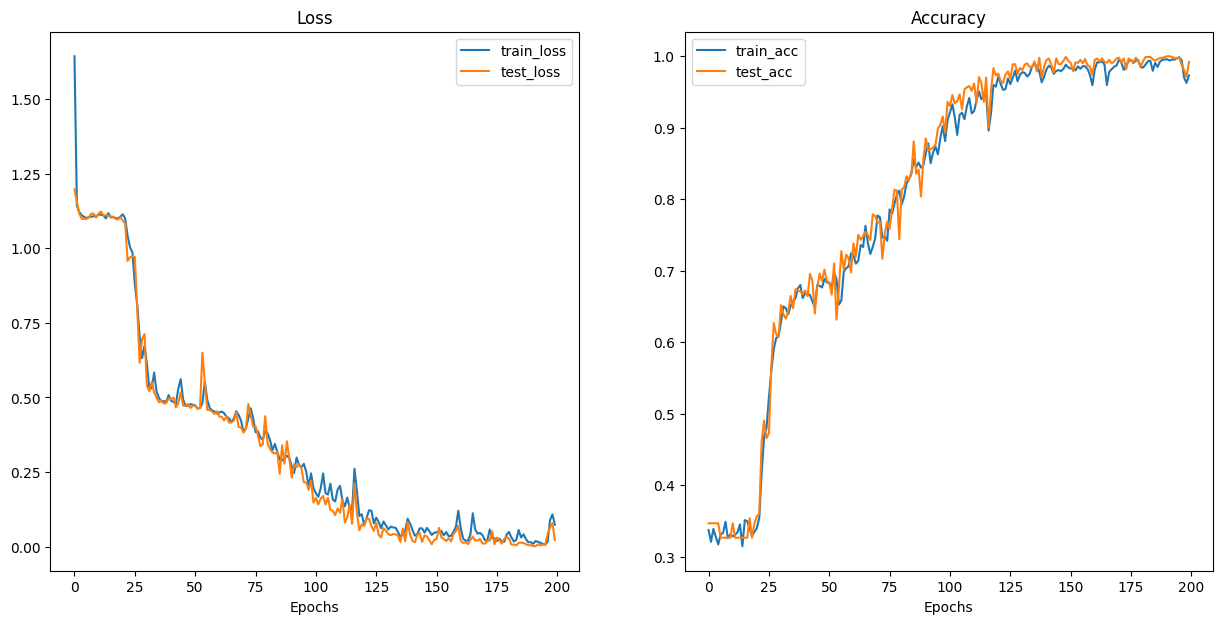

In [23]:
plot_loss_curves(results=model_results)

## Confussion Matrix

In [24]:
y_preds=[]

model_prueba.eval()
prediction_acc=0
with torch.inference_mode():
    for X,y in tqdm(test_dataloader,desc="Making predictions"):
        X,y=X.to(device),y.to(device)
        y_logits=model_prueba(X)
        y_pred=torch.argmax(torch.softmax(y_logits,dim=1),dim=1)
        # y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        prediction_acc+=(y_pred == y).sum().item() / len(y_pred)

prediction_acc=prediction_acc/len(test_dataloader)

y_pred_tensor=torch.cat(y_preds)

print("Accuracy: ",prediction_acc)
print("Predictions: ",y_pred_tensor)

Making predictions: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]

Accuracy:  0.9919354838709676
Predictions:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


conf_mat=ConfusionMatrix(num_classes=Hyper_Parameters.NUM_CLASSES.value,task='multiclass')
targets_tensor = torch.tensor(test_dataset.targets)
confmat_tensor=conf_mat(preds=y_pred_tensor,
                    target=targets_tensor) #target == label

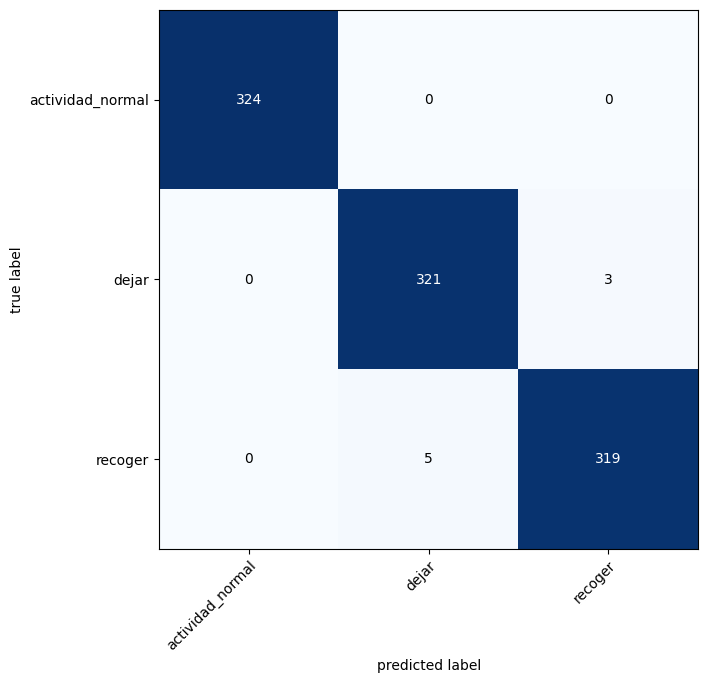

In [26]:
fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                            class_names=class_names,
                            figsize=(10,7))

## Codigos de Prueba

In [46]:
import re
root=os.getcwd()

targ_dir=os.path.join(root,"oficial_set","train")

videos_path=list(pathlib.Path(targ_dir).glob("*/*"))

video_path=videos_path[0]

frames_ordenados=sorted(os.listdir(video_path), key=lambda x: int(re.findall(r'\d+', x)[0]))

frames=[]
for frame in frames_ordenados:
    frame_path=os.path.join(video_path,frame)
    image=cv2.imread(frame_path)
    image=transform_videos(image)
    frames.append(image)


## Descarga de modelos

In [27]:
from pathlib import Path

#Create model directory path
MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)
#Create model save
MODEL_NAME='video_vision_transformer_200_epochs.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

WindowsPath('models/video_vision_transformer_200_epochs.pth')

In [28]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_prueba.state_dict(),
        f=MODEL_SAVE_PATH)

Saving model to: models\video_vision_transformer_200_epochs.pth


## Load model

In [20]:
ViVit_instance=ViViTFactorized(in_channels=3,num_classes=3,num_frames=10,img_size=64)

ViVit_instance.load_state_dict(torch.load(f="models/video_vision_transformer_200_epochs.pth"))

ViVit_instance.to(device)

c:\Proyectos\PAPER\venv\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


ViViTFactorized(
  (patch_embedding): TubeletEmbedding(
    (patcher): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    (flatten): Flatten(start_dim=3, end_dim=4)
  )
  (spatial_encoder): TransformerEncoder(
    (transformer_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): Mul

In [23]:
y_preds=[]

ViVit_instance.eval()
prediction_acc=0
with torch.inference_mode():
    for X,y in tqdm(test_dataloader,desc="Making predictions"):
        X,y=X.to(device),y.to(device)
        y_logits=ViVit_instance(X)
        y_pred=torch.argmax(torch.softmax(y_logits,dim=1),dim=1)
        # y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        prediction_acc+=(y_pred == y).sum().item() / len(y_pred)

prediction_acc=prediction_acc/len(test_dataloader)

y_pred_tensor=torch.cat(y_preds)

print("Accuracy: ",prediction_acc)
print("Predictions: ",y_pred_tensor)

Making predictions: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]

Accuracy:  0.9919354838709676
Predictions:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,